In [1]:
import gdown
import pandas as pd
import random
import json

In [ ]:
# gdown.download('https://drive.google.com/file/d/17NBXx6l_6znStM52RJOKKKlxnHigavzq/view', fuzzy=True)

In [ ]:
# tar -xvzf hackathon_objects.tar.gz

In [2]:
goods_data = pd.read_parquet('../datasets/train_data.parquet')

goods_pairs = pd.read_parquet('../datasets/train_pairs_w_target.parquet')

In [3]:
def symm_pairs(df):
    # todo: complete cliques of goods
    
    df2 = df.copy()
    cols = ["variantid1", "variantid2"]
    for c in cols:
        if c not in df2.columns:
            raise UserWarning
    df2 = df2.rename(columns={cols[0]: cols[1], cols[1]: cols[0]})
    return pd.concat([df, df2]).drop_duplicates()

In [146]:
import torch
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader


class ContrastiveDataset(Dataset):
    def __init__(self, original_dataset, pairs_dataset, embedding_columns, mode = True):
        self.original_dataset = original_dataset.set_index('variantid')
        self.pairs_dataset = pairs_dataset
        self.embedding_columns = embedding_columns
        self.dataset = None
        self.mode = mode
        if self.mode:
            self.prepare_dataset()

        else:
            self.prepare_test_dataset()
        self.prepare_data()
        

    def prepare_dataset(self):
        neg_pairs =  self.pairs_dataset[ self.pairs_dataset.target ==0.].groupby('variantid1').variantid2.apply(lambda x: list(x)).to_frame()
        pos_pairs =  self.pairs_dataset[ self.pairs_dataset.target ==1.].groupby('variantid1').variantid2.apply(lambda x: list(x)).to_frame()
        self.dataset = pos_pairs.merge(neg_pairs, how = 'outer', left_index = True, right_index = True, suffixes = ['_pos', '_neg'])
        sol = pd.Series(np.where(self.dataset.variantid2_pos.notnull(), self.dataset.variantid2_pos, pd.Series(self.dataset.index).apply(lambda x: [x])))
        self.dataset['variantid2_pos'] = sol.set_axis(self.dataset.index)
        ld = pd.Series(self.dataset.index).sample(frac = 1).apply(lambda x: [x])
        sol = pd.Series(np.where(self.dataset.variantid2_neg.notnull(), self.dataset.variantid2_neg, ld))
        self.dataset['variantid2_neg'] = sol.set_axis(self.dataset.index)
        self.dataset = self.dataset.reset_index()

        
    def prepare_data(self):
        self.original_dataset = self.original_dataset.apply(lambda x: torch.cat([torch.tensor(x['main_pic_embeddings_resnet_v1'][0]), torch.tensor(x['name_bert_64'])], axis =0), axis =1)
    
    def prepare_test_dataset(self):
        self.dataset = self.pairs_dataset[['variantid1']].reset_index(drop=True)



    def __getitem__(self, index):
        original_idx = self.dataset.loc[index].variantid1
        if self.mode:
            positive_idx = self.dataset.loc[index].variantid2_pos
            negative_idx = self.dataset.loc[index].variantid2_neg
            if len(positive_idx)>1:
                val = np.random.choice(len(positive_idx), 1)[0]
                positive_idx = positive_idx[val]
            else:
                positive_idx = positive_idx[0]
            if len(negative_idx)>1:
                val = np.random.choice(len(negative_idx), 1)[0]
                negative_idx = negative_idx[val]
            else:
                negative_idx = negative_idx[0]
            positive_pair = self.original_dataset.loc[positive_idx]
            negative_pair = self.original_dataset.loc[negative_idx]
            original_data = self.original_dataset.loc[original_idx]
          #  print(original_data)
            return original_data, positive_pair, negative_pair, original_idx
        else:
            original_data = self.original_dataset.loc[original_idx]
            return original_data, original_idx


    def __len__(self):
        return len(self.dataset)



# Actual data

In [7]:
symm_goods_pairs = symm_pairs(goods_pairs)

In [ ]:
pos_pairs = symm_goods_pairs[symm_goods_pairs.target ==1].groupby('variantid1').variantid2.apply(lambda x: list(x)).to_frame()
#checking if lists contain duplicates
pos_pairs.variantid2.apply(lambda x: len(x) !=len(set(x))).value_counts()
# добавить все симметричные positive pairs
pos_pairs.variantid2.str.len().value_counts()

1     189650
2      18977
3       3806
4       1403
5        734
6        561
7        380
8        287
9        247
10       190
11       166
12       129
13       115
14        72
15        55
16        40
17        24
18        22
20        15
19        14
21         6
22         5
25         3
26         3
23         2
27         2
24         2
28         1
Name: variantid2, dtype: int64

In [8]:
embedding_columns = ['main_pic_embeddings_resnet_v1', 'name_bert_64']

contrastive_dataset = ContrastiveDataset(goods_data, symm_goods_pairs, embedding_columns, mode= True)
contrastive_dataloader = DataLoader(contrastive_dataset, batch_size=128, shuffle=False, drop_last= True, num_workers = 8)
next(iter(contrastive_dataloader))[0].shape

torch.Size([128, 192])

In [9]:
yt = next(iter(contrastive_dataloader))
yt[0].shape, yt[1].shape, yt[2].shape

(torch.Size([128, 192]), torch.Size([128, 192]), torch.Size([128, 192]))

# Basic train example

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm

In [11]:
#!g1.1

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [12]:
#!g1.1
class ContrastiveModel(nn.Module):
    def __init__(self, input_size, hidden_size, embedding_size):
        super(ContrastiveModel, self).__init__()
        
        self.input_size = input_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, embedding_size)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def triplet_loss(anchor, positive, negative, margin=1.0):
    distance_positive = torch.norm(anchor - positive, dim=1)
    distance_negative = torch.norm(anchor - negative, dim=1)
    loss = torch.clamp(distance_positive - distance_negative + margin, min=0.0).mean()
    return loss

# Example parameters
input_size = 192
hidden_size = 64
embedding_size = 32
learning_rate = 0.001
num_epochs = 10

# Create an instance of the model
model = ContrastiveModel(input_size, hidden_size, embedding_size).to(device)

# Define the optimizer and the loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train loop
def train(model, contrastive_dataloader, optimizer):
    for epoch in tqdm(range(num_epochs)):
        total_loss = 0.0
        
        for original_data, positive_pair, negative_pair, _ in tqdm(contrastive_dataloader):
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            anchor = model(original_data.to(device))
            positive = model(positive_pair.to(device))
            negative = model(negative_pair.to(device))
            
            # Compute the triplet loss
            loss = triplet_loss(anchor, positive, negative)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
    #     print(loss.item())
            total_loss += loss.item()
        
        average_loss = total_loss / len(contrastive_dataloader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss:.4f}")


In [ ]:
torch.save(model.state_dict(), 'contrastive_ozon.pt')

In [13]:
model = ContrastiveModel(input_size, hidden_size, embedding_size).to(device)
model.load_state_dict(torch.load('./contrastive_ozon.pt'))

<All keys matched successfully>

In [14]:
def predict(model, dataloader):
    y_idxs = []
    y_embed = []
    for orig, _, _, idx in tqdm(dataloader):
        embed = model(orig.to(device))
        y_idxs.extend([i.detach().cpu().item() for i in idx])
        y_embed.extend([[j.item() for j in i.detach().cpu()] for i in embed])
    return y_idxs, y_embed

y_idxs, y_embed = predict(model, contrastive_dataloader)

        


  0%|          | 0/3568 [00:00<?, ?it/s]

In [15]:
embed = pd.DataFrame({'variant': y_idxs, 'embed': y_embed})
classif = goods_pairs.merge(embed, left_on = 'variantid1', right_on = 'variant', how = 'left', suffixes = ['', '_1'])
classif = classif.merge(embed, left_on = 'variantid2', right_on='variant', how = 'left', suffixes = ['', '_2'])
classif.drop(['variant', 'variant_2'],axis = 1, inplace = True)

In [16]:
classif

,target,variantid1,variantid2,embed,embed_2
0,0.0,51197862,51198054,"[1.4284183979034424, -1.4612640142440796, 1.39...","[-0.24508824944496155, -2.4218990802764893, 0...."
1,1.0,53062686,536165289,"[1.3955268859863281, -3.4774487018585205, 2.36...","[0.7183371782302856, -2.4540185928344727, 1.94..."
2,1.0,53602615,587809782,"[1.2483365535736084, -3.1211259365081787, 1.75...","[1.0294300317764282, -3.227156162261963, 2.021..."
3,1.0,53888651,89598677,"[-0.6405757665634155, 1.1252756118774414, 1.11...","[-0.328825980424881, 0.7972545027732849, 1.682..."
4,0.0,56930698,551526166,"[-1.944229245185852, 0.006754197180271149, 2.9...","[-2.197075605392456, 0.2249535620212555, 3.427..."
...,...,...,...,...,...
306535,0.0,817327230,822083612,"[-2.483705759048462, 2.7673466205596924, 2.698...","[-2.169738531112671, 2.461132764816284, 2.5446..."
306536,0.0,817560551,818069912,"[0.02244863659143448, -0.36197635531425476, 1....","[-0.022487543523311615, 0.02435687929391861, 2..."
306537,0.0,817854719,817857267,"[0.3968181312084198, 0.6064795851707458, 2.543...","[0.36862489581108093, 0.7291695475578308, 2.66..."
306538,0.0,820036017,820037019,"[-1.1647974252700806, 1.0150843858718872, 0.96...","[-0.6115685701370239, 0.6899463534355164, 0.55..."


In [65]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
def get_pic_features(main_pic_embeddings_1,
                     main_pic_embeddings_2):
    """Calculate distances percentiles for 
    pairwise pic distances. Percentiles are useful 
    when product has several pictures.
    """
     
    embed= list(np.abs(np.array(main_pic_embeddings_1)[None, ...] - np.array(main_pic_embeddings_2)[None, ...])[0])

    cos_sim = cosine_similarity(
        np.array(main_pic_embeddings_1)[None, ...], np.array(main_pic_embeddings_2)[None, ...]
    )[0][0]
    

    # pair_features = []
    # pair_features += np.percentile(dist_m, percentiles).tolist()

    return embed, cos_sim

In [66]:

classif[["embed_dif", "cos_sim", ]] = (
    classif[["embed", "embed_2"]].apply(
        lambda x: pd.Series(get_pic_features(*x)), axis=1
    )
)

In [ ]:
classif = classif.merge(goods_data[['variantid', 'categories']], left_on = 'variantid1', right_on = 'variantid', how = 'left')
classif["cat3"] = classif["categories"].apply(lambda x: json.loads(x)["3"])
cat3_counts = classif["cat3"].value_counts().to_dict()
classif["cat3_grouped"] = classif["cat3"].apply(lambda x: x if cat3_counts[x] > 1000 else "rest")

In [70]:
dikt_categories= {i: j for i, j in zip(classif.cat3_grouped.unique(), range(classif.cat3_grouped.nunique()))}
classif['category'] = classif.cat3_grouped.map(dikt_categories)
embeddings = pd.DataFrame(classif['embed_dif'].tolist())
data = pd.concat([classif, embeddings], axis = 1)
data= data[['target', 'variantid1', 'variantid2',  'cos_sim', 'cat3_grouped', 'category']+list(embeddings.columns)]

In [102]:
data

,target,variantid1,variantid2,cos_sim,cat3_grouped,category,0,1,2,3,...,22,23,24,25,26,27,28,29,30,31
0,0.0,51197862,51198054,0.623732,"Сетевые фильтры, разветвители и удлинители",0,1.673507,0.960635,1.054015,1.343579,...,0.389123,0.773040,0.631099,1.648258,0.793561,0.416819,0.995951,0.070998,1.197331,1.227799
1,1.0,53062686,536165289,0.994505,Расходник для печати,1,0.677190,1.023430,0.417898,0.006071,...,0.010140,0.523998,0.494322,0.461861,0.654018,0.207620,0.002890,0.166982,0.258356,0.178325
2,1.0,53602615,587809782,0.970200,Расходник для печати,1,0.218907,0.106030,0.271251,1.783887,...,0.694797,0.285450,0.964310,0.978557,0.417363,1.132542,0.514578,0.235123,0.641277,0.985373
3,1.0,53888651,89598677,0.996188,Смарт-часы,2,0.311750,0.328021,0.568941,0.075371,...,0.321609,0.176101,0.890557,0.623743,0.738596,0.433111,0.100743,0.149948,0.025988,0.083915
4,0.0,56930698,551526166,0.997101,Батарейки и аккумуляторы,3,0.252846,0.218199,0.444633,0.427305,...,0.049424,0.045744,0.215887,0.163548,0.156159,0.204021,0.342430,0.235759,0.081980,0.072505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306492,0.0,817327230,822083612,0.998723,"Смартфоны, планшеты, мобильные телефоны",19,0.313967,0.306214,0.153408,0.323915,...,0.027857,0.136742,0.321293,0.109738,0.011797,0.046232,0.061233,0.077988,0.003322,0.055470
306493,0.0,817560551,818069912,0.844608,Карты памяти и флешки,32,0.044936,0.386333,0.962070,1.266438,...,0.335529,0.435352,0.563472,0.100314,0.258589,0.525956,0.015843,0.555871,0.248750,0.076895
306494,0.0,817854719,817857267,0.987269,"Смартфоны, планшеты, мобильные телефоны",19,0.028193,0.122690,0.120951,1.501154,...,0.296399,0.451560,1.507184,0.890056,0.475255,1.458777,0.083591,0.311222,0.362280,0.492931
306495,0.0,820036017,820037019,0.996814,Кабели и переходники,11,0.553229,0.325138,0.413938,0.637389,...,0.538363,0.112529,0.033104,0.403969,0.041021,0.091877,0.261687,0.077107,0.317741,0.265547


In [165]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test = train_test_split(
    data, 
    test_size=0.1, random_state=42, stratify=classif[["target", "cat3_grouped"]]
)

y_test = X_test[["target", "variantid1", "variantid2", ]]
cat_test = X_test["cat3_grouped" ]
X_test = X_test.drop(["target", "cat3_grouped"], axis=1)

y_train = X_train["target"]
cat_train = X_train["cat3_grouped"]
X_train = X_train.drop(["target", "cat3_grouped"], axis=1)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test =scaler.fit(X_test)
train_pool = Pool(
    data=X_train,
    label=y_train,
)
eval_pool = Pool(
    data=X_test,
    label=y_test['target'],
)

In [ ]:
lgbm_params = {'boosting_type': 'gbdt',
                   'random_state': 1234,
                   'n_jobs': 10,
               #    'verbose': 0,
                   'num_iterations': 500,
                   'early_stopping_round': 50,
                   'metric': 'auc'}
model_lgb = lgb.LGBMClassifier(**lgbm_params)

In [162]:
X_train

,variantid1,variantid2,cos_sim,category,0,1,2,3,4,5,...,22,23,24,25,26,27,28,29,30,31
273279,585761439,668832138,0.976883,12,1.133191,1.018362,0.008552,1.316395,0.399907,1.102293,...,0.387588,0.623570,1.147763,0.825943,0.399853,0.095034,0.396525,0.660973,0.303930,0.480819
238790,619286696,621116550,0.984191,38,0.123698,0.026519,0.954907,0.939173,0.455338,0.633780,...,0.466312,0.006484,0.090487,0.422254,0.935708,0.174652,0.562615,0.490223,0.170352,0.451690
255398,91831819,227759124,0.972944,4,0.078991,0.255001,1.748248,1.445945,1.598725,0.818173,...,0.465432,0.371152,0.353445,0.574737,0.387793,0.929074,1.070969,0.445361,0.940204,0.366109
300739,517335122,575552776,0.973552,11,1.676312,1.157513,0.342284,0.634962,0.365987,0.258864,...,0.947922,0.138093,0.018915,0.616623,0.568840,0.043627,0.236340,0.616577,0.259452,0.082921
170171,796419334,796419987,0.958383,1,0.645178,0.597415,1.008847,1.512144,1.347485,2.433571,...,0.863894,0.152996,0.852653,2.886706,0.582752,1.093985,0.681818,1.291175,1.882065,1.142346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71026,743473284,743919973,0.980273,19,0.826188,0.788618,0.991384,0.470750,0.683037,1.919913,...,0.404192,0.441690,0.958117,1.457672,1.308280,0.044610,0.696995,0.741843,0.572188,0.549897
95811,88971046,600796417,0.982178,12,0.191869,0.789435,0.325551,1.033774,1.036057,1.023052,...,0.252520,0.645139,1.072547,0.846948,0.731172,0.681168,0.193382,1.594503,0.693944,0.574876
110776,383607389,383681652,0.565436,35,0.380456,2.803837,0.293386,0.167529,1.182785,0.955094,...,0.716570,1.363246,0.608796,0.238952,1.673013,0.898710,0.371573,1.527090,1.644741,0.325110
69672,138315125,140659638,0.996077,7,0.754407,0.773776,0.087583,0.502832,0.324442,0.601613,...,0.016632,0.317359,0.713663,0.348271,0.137891,0.293599,0.394871,0.061697,0.071209,0.035090


In [166]:
model_cat = CatBoostClassifier()

model_cat.fit(
   train_pool,
    eval_set = eval_pool,
 #   n_jobs=10, 
    plot=True,
    verbose=True,
    use_best_model=True,
    early_stopping_rounds=50,
    metric_period=100
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.126985
0:	learn: 0.6649372	test: 0.6652003	best: 0.6652003 (0)	total: 23.6ms	remaining: 23.6s


100:	learn: 0.5195262	test: 0.5208332	best: 0.5208332 (100)	total: 1.76s	remaining: 15.7s
200:	learn: 0.5055442	test: 0.5101024	best: 0.5101024 (200)	total: 3.55s	remaining: 14.1s
300:	learn: 0.4977504	test: 0.5065206	best: 0.5064976 (297)	total: 5.34s	remaining: 12.4s
400:	learn: 0.4912834	test: 0.5037831	best: 0.5037771 (399)	total: 7.15s	remaining: 10.7s
500:	learn: 0.4855163	test: 0.5023231	best: 0.5023231 (500)	total: 8.95s	remaining: 8.91s
600:	learn: 0.4799929	test: 0.5008341	best: 0.5008341 (600)	total: 10.8s	remaining: 7.14s
700:	learn: 0.4749422	test: 0.5000851	best: 0.5000298 (670)	total: 12.5s	remaining: 5.35s
800:	learn: 0.4702180	test: 0.4998654	best: 0.4998299 (797)	total: 14.3s	remaining: 3.56s
900:	learn: 0.4655481	test: 0.4994833	best: 0.4994722 (899)	total: 16.1s	remaining: 1.77s
999:	learn: 0.4611650	test: 0.4989039	best: 0.4989039 (999)	total: 17.9s	remaining: 0us

bestTest = 0.498903854
bestIteration = 999



In [167]:
import numpy as np
from sklearn.metrics import precision_recall_curve, auc


def pr_auc_macro(
    target_df: pd.DataFrame,
    predictions_df: pd.DataFrame,
    prec_level: float = 0.75,
    cat_column: str = "cat3_grouped",
    cat_df: pd.DataFrame = cat_test
) -> float:
    
    df = target_df.merge(predictions_df, on=["variantid1", "variantid2"])
    
    y_true = df["target"]
    y_pred = df["scores"]
    categories = cat_df
    
    weights = []
    pr_aucs = []

    unique_cats, counts = np.unique(categories, return_counts=True)

    for i, category in enumerate(unique_cats):
        cat_idx = np.where(categories == category)[0]
        y_pred_cat = y_pred[cat_idx]
        y_true_cat = y_true[cat_idx]

        y, x, thr = precision_recall_curve(y_true_cat, y_pred_cat)
        gt_prec_level_idx = np.where(y >= prec_level)[0]

        try:
            pr_auc_prec_level = auc(x[gt_prec_level_idx], y[gt_prec_level_idx])
            if not np.isnan(pr_auc_prec_level):
                pr_aucs.append(pr_auc_prec_level)
                weights.append(counts[i] / len(categories))
        except ValueError as err:
            pr_aucs.append(0)
            weights.append(0)
    return np.average(pr_aucs, weights=weights)

In [168]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve, auc


def pr_auc_macro(
    target_df: pd.DataFrame,
    predictions_df: pd.DataFrame,
    prec_level: float = 0.75,
    cat_column: str = "cat3_grouped",
    cat_df: pd.DataFrame = cat_test
) -> float:
    
    df = target_df.merge(predictions_df, on=["variantid1", "variantid2"])
    
    y_true = df["target"]
    y_pred = df["scores"]
    categories = cat_df
    
    weights = []
    pr_aucs = []

    unique_cats, counts = np.unique(categories, return_counts=True)

    for i, category in enumerate(unique_cats):
        cat_idx = np.where(categories == category)[0]
        y_pred_cat = y_pred[cat_idx]
        y_true_cat = y_true[cat_idx]

        y, x, thr = precision_recall_curve(y_true_cat, y_pred_cat)
        gt_prec_level_idx = np.where(y >= 0)[0]

        try:
            pr_auc_prec_level = auc(x[gt_prec_level_idx], y[gt_prec_level_idx])
            if not np.isnan(pr_auc_prec_level):
                pr_aucs.append(pr_auc_prec_level- prec_level)
                weights.append(counts[i] / len(categories))
        except ValueError as err:
            pr_aucs.append(0)
            weights.append(0)
    return np.average(pr_aucs, weights=weights)


In [169]:
X_test["scores"] = model_cat.predict_proba(X_test)[:, 1]

In [170]:
pr_auc_macro_metr = pr_auc_macro(
    target_df=y_test, 
    predictions_df=X_test,
    prec_level=0.75,
    cat_column="cat3_grouped", 
    cat_df= cat_test
)

pr_auc_macro_metr

-0.15007409624254278

In [ ]:
#используется только одна картинка, можно делать positive pairs со всеми

<AxesSubplot:>

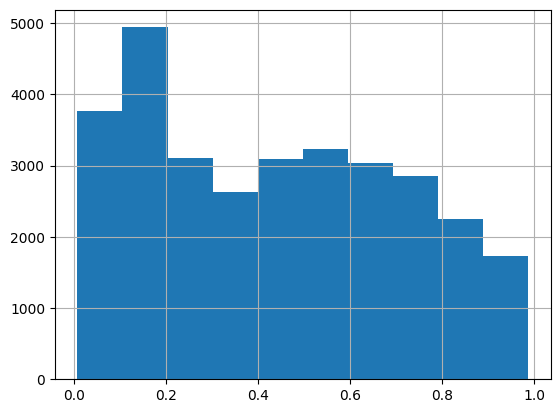

In [141]:
X_test["scores"].hist()

# Submission

In [171]:
#test_pairs = pd.read_parquet("../datasets/test_pairs_wo_target.parquet")
test_pairs = pd.read_csv("../datasets/test_for_participants.csv")
test_etl = pd.read_parquet("../datasets/test_data.parquet")

In [172]:
embedding_columns = ['main_pic_embeddings_resnet_v1', 'name_bert_64']
symm_goods_pairs = symm_pairs(test_pairs)
dataset_test = ContrastiveDataset(test_etl, symm_goods_pairs, embedding_columns, mode = False)
test_dataloader = DataLoader(dataset_test, batch_size=128, shuffle=False, drop_last= False, num_workers =7)

In [173]:
yt = next(iter(test_dataloader))

In [174]:
def predict(model, dataloader):
    y_idxs = []
    y_embed = []
    for orig, idx in tqdm(dataloader):
        embed = model(orig.to(device))
        y_idxs.extend([i.detach().cpu().item() for i in idx])
        y_embed.extend([[j.item() for j in i.detach().cpu()] for i in embed])
    return y_idxs, y_embed

y_idxs, y_embed = predict(model, test_dataloader)

        


  0%|          | 0/283 [00:00<?, ?it/s]

In [192]:
embed = pd.DataFrame({'variant': y_idxs, 'embed': y_embed})
classif = test_pairs.merge(embed, left_on = 'variantid1', right_on = 'variant', how = 'left', suffixes = ['', '_1'])
classif = classif.merge(embed, left_on = 'variantid2', right_on='variant', how = 'left', suffixes = ['', '_2'])
classif.drop(['variant', 'variant_2'],axis = 1, inplace = True)

In [193]:
classif

,variantid1,variantid2,embed,embed_2
0,372065731,372070671,"[2.1447460651397705, -3.76627779006958, 1.3890...","[1.5221861600875854, -2.3261563777923584, 1.59..."
1,528068358,533445916,"[-0.22024646401405334, -1.0444872379302979, 3....","[0.9306674003601074, -1.9474190473556519, 3.00..."
2,480899084,480899989,"[-2.278977155685425, 0.7011398673057556, 1.433...","[-3.3785808086395264, -0.25267452001571655, 0...."
3,384479474,488458602,"[-4.418258190155029, 5.7528462409973145, -0.46...","[-3.023808479309082, 4.010915756225586, -0.927..."
4,658044199,663187587,"[-1.571662187576294, 2.6026253700256348, 0.715...","[-3.479339361190796, 4.655041217803955, 2.5673..."
...,...,...,...,...
19002,405934001,695957034,"[-5.055927753448486, -1.0235984325408936, 1.40...","[-4.459354877471924, -1.6864765882492065, 1.40..."
19003,692224892,692246989,"[-1.277388572692871, -0.18251940608024597, 0.4...","[-1.4491735696792603, 1.6245179176330566, 0.09..."
19004,388824213,658486072,"[-5.3358330726623535, 3.495398759841919, 3.124...","[-3.4910335540771484, 2.548637628555298, 4.581..."
19005,479858327,480111601,"[-1.7428889274597168, -0.2176881730556488, 3.1...","[-2.3007640838623047, 0.4184962809085846, 3.14..."


In [194]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
def get_pic_features(main_pic_embeddings_1,
                     main_pic_embeddings_2):
    """Calculate distances percentiles for 
    pairwise pic distances. Percentiles are useful 
    when product has several pictures.
    """
     
    embed= list(np.abs(np.array(main_pic_embeddings_1)[None, ...] - np.array(main_pic_embeddings_2)[None, ...])[0])

    cos_sim = cosine_similarity(
        np.array(main_pic_embeddings_1)[None, ...], np.array(main_pic_embeddings_2)[None, ...]
    )[0][0]
    

    # pair_features = []
    # pair_features += np.percentile(dist_m, percentiles).tolist()

    return embed, cos_sim

In [195]:

classif[["embed_dif", "cos_sim", ]] = (
    classif[["embed", "embed_2"]].apply(
        lambda x: pd.Series(get_pic_features(*x)), axis=1
    )
)

In [196]:
classif = classif.merge(test_etl[['variantid', 'categories']], left_on = 'variantid1', right_on = 'variantid', how = 'left')
classif["cat3"] = classif["categories"].apply(lambda x: json.loads(x)["3"])
cat3_counts = classif["cat3"].value_counts().to_dict()


In [198]:
classif["cat3_grouped"] = classif["cat3"].apply(lambda x: x if cat3_counts[x] > 1000 else "rest")

In [202]:
dikt_categories= {i: j for i, j in zip(classif.cat3_grouped.unique(), range(classif.cat3_grouped.nunique()))}
classif['category'] = classif.cat3_grouped.map(dikt_categories)
embeddings = pd.DataFrame(classif['embed_dif'].tolist())
data = pd.concat([classif, embeddings], axis = 1)

In [205]:
data= data[['variantid1', 'variantid2',  'cos_sim', 'category']+list(embeddings.columns)]

In [206]:
data

,variantid1,variantid2,cos_sim,category,0,1,2,3,4,5,...,22,23,24,25,26,27,28,29,30,31
0,372065731,372070671,0.951600,0,0.622560,1.440121,0.208853,1.122812,0.151113,0.227434,...,0.538848,0.164657,0.785533,0.075542,0.932148,1.129492,0.063640,0.849180,1.172207,0.126322
1,528068358,533445916,0.969071,1,1.150914,0.902932,0.518876,0.329372,0.568794,0.003181,...,0.022568,0.075217,0.027044,0.219103,0.730736,0.066135,1.186606,0.189221,0.213108,0.402445
2,480899084,480899989,0.857573,2,1.099604,0.953814,0.870593,1.121283,2.054214,0.855631,...,0.342919,0.655844,1.397563,1.850674,0.378148,0.520604,0.226502,0.130737,1.248688,0.651333
3,384479474,488458602,0.982335,3,1.394450,1.741930,0.463496,0.719602,1.525337,1.059816,...,0.467850,0.841428,0.985009,0.076893,0.091460,0.228351,0.582469,1.125786,0.680165,0.318172
4,658044199,663187587,0.917276,4,1.907677,2.052416,1.851978,1.770392,1.090612,0.176635,...,1.532235,0.580072,0.637252,1.238954,0.417881,0.890135,0.216282,0.683784,0.381733,0.629260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19002,405934001,695957034,0.983202,3,0.596573,0.662878,0.002240,1.079975,0.003552,0.415293,...,0.438131,0.160015,0.445951,0.456788,0.345610,0.315812,0.582202,0.710776,0.215060,0.953974
19003,692224892,692246989,0.870026,3,0.171785,1.807037,0.374506,0.371728,2.533723,1.069831,...,0.701245,1.433695,1.817888,0.374377,1.579910,0.637830,0.255533,1.790015,1.494572,0.495178
19004,388824213,658486072,0.938327,3,1.844800,0.946761,1.457162,2.963683,1.034611,0.212271,...,0.985646,0.193266,1.746356,0.356987,1.114766,2.269139,0.698935,0.760156,0.108657,1.212864
19005,479858327,480111601,0.981167,6,0.557875,0.636184,0.027762,0.591791,0.530506,0.264113,...,0.371078,0.084736,0.663517,0.608183,0.720040,0.563936,0.041671,0.273147,0.089615,0.010105


In [207]:
classif["scores"] = model_cat.predict_proba(data)[:, 1]

In [208]:
submit = classif[['variantid1', 'variantid2', 'scores']]

In [209]:
submit.to_csv('submition_2.csv', index=False, sep = ',')

In [210]:
submit

,variantid1,variantid2,scores
0,372065731,372070671,0.246572
1,528068358,533445916,0.334928
2,480899084,480899989,0.178535
3,384479474,488458602,0.675027
4,658044199,663187587,0.381631
...,...,...,...
19002,405934001,695957034,0.782935
19003,692224892,692246989,0.283634
19004,388824213,658486072,0.484977
19005,479858327,480111601,0.654282
